# PREPROCESSING

In [1]:
# processes a textfile according with skip-gram algorithm
# returns a list in the following format [[7,4],[42,44], ...]
from preprocessing import Preprocess
from utils import createWordPairs

# Variables: 
#     threshold: how many emojis count as a sequence
#     window_size: determine how far to the left and right of center_word the skip-gram algo forms word_pairs
threshold = 2
window_size = 8

indexes = Preprocess('./data/initializationSet.txt', threshold)
trainingCorpus = Preprocess('./data/trainingSet.txt', threshold)
validationCorpus = Preprocess('./data/validationSet.txt', threshold)

trainingPairs = createWordPairs(indexes, trainingCorpus, window_size)
validationPairs = createWordPairs(indexes, validationCorpus, window_size)

'🆔'
'🛢'
'🛢'
'🔕'
'🔕'
'🔕'
'🔕'
'🔢'
'◾'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'⬜'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'🔕'
'▪'
'♌'
'🔠'
'▫'
'▫'
'🔕'
'◾'
'🔕'
'🔕'
'🔕'
'◼'
'⏯'
'⏯'
'◾'
'❎'
'⏯'
'⏯'
'⏯'
'⏯'
'◼'
'⏯'
'⏯'
'⏯'
'⏯'
'⏯'
'📤'
'❎'
'▫'
'◾'
'◾'
'❎'
'♋'
'◼'
'◾'
'💈'
'◾'
'◾'
'◾'
'⏯'
'💈'
'🎦'
'⏯'
'❎'
'💈'
'⏯'
'◼'
'🗾'
'⬜'
'▫'
'❎'
'🚋'
'⏯'
'⏯'
'⏯'
'🔢'
'⏯'
'📆'
'☣'
'▪'
'⏯'
'▫'
'◾'
'☣'
'❎'
'🔯'
'❎'
'💈'
'◾'
'❎'
'❎'
'▫'
'◾'
'▫'
'❎'
'↪'
'🔖'
'↪'
'◼'
'▫'
'⏯'
'▫'
'⏯'
'❎'
'▫'
'⏯'
'◾'
'🎦'
'◾'
'▫'
'◾'
'▪'
'🎦'
'◾'
'⏯'
'◾'
'◾'
'◾'
'◾'
'◾'
'📄'
'📄'
'📄'
'▫'
'⏯'
'⏯'
'⏯'
'⏯'
'⏯'
'🎦'
'⏯'
'💈'
'🚇'
'🎦'
'⏯'
'📛'
'☣'
'⏯'
'📛'
'⏯'
'⏯'
'⏯'
'🎦'
'⏯'
'⏯'
'❎'
'◾'
'🔕'
'📛'
'📆'
'📆'
'📆'
'〰'
'📛'
'🔕'
'〰'
'◾'
'🔢'
'🔏'
'🔏'
'🔢'
'⏯'
'🔏'
'🔏'
'🛐'
'◾'
'🔖'
'🔖'
'🈷'
'㊙'
'🈂'
'▫'
'🚋'
'🚇'
'💈'
'📆'
'▫'
'💈'
'▫'
'♉'
'◼'
'◼'
'◼'
'⏯'
'💈'
'💈'
'👲'
'↩'
'⏯'
'🔕'
'📆'
'📆'
'📆'
'◾'
'☣'
'▫'
'◾'
'◾'
'⏯'
'🗾'
'📋'
'🚉'
'🚉'
'🚇'
'🏺'
'🏺'
'🚱'
'⏯'
'❎'
'🎦'
'🎦'
'🎦'
'⏯'
'⏯'
'⏯'
'⏯'
'⏯'
'❎'
'⏯'
'❎'
'⏯'
'▫'
'🛄'
'❎'
'🛄'
'🛄'
'⏯'
'🛄'
'📁'
'🛄'
'🛄'
'⏯'
'⏯'
'💈'
'⏯'
'🔳'
'🔳'
'🛄'


# TRAINING

In [2]:
# best trainable after extending the data_rate_limit..
# use terminal cmd w/ MAC: "jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000"

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

from dataset import LoadedDataSet
from model import Word2Vec
from utils import EarlyStopping

# HyperParams
dimensionSize = 400
num_epochs = 600
lr = 0.001
batchSize = 150
patience = 25
save_name = "smalldims.w2v"
verbose = True

trainingDataset = LoadedDataSet(trainingPairs)
trainingLoader = DataLoader(trainingDataset, batchSize, shuffle=True) 
validationDataset = LoadedDataSet(validationPairs)
validationLoader = DataLoader(validationDataset, batchSize, shuffle=True) 

model = Word2Vec(indexes.vocabulary_size, dimensionSize)
optimizer = torch.optim.Adam(model.parameters(), lr)
# Variables for Scheduler:
mode='min'
factor=0.1
patience=10
verbose=True
threshold=0.0001
threshold_mode='rel'
cooldown=0
min_lr=0
eps=1e-08
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode, factor, patience, verbose, threshold, threshold_mode, cooldown, min_lr, eps)

# initialize the early_stopping object
early_stopping = EarlyStopping(patience, verbose, save_name)
avg_train_losses = []
avg_valid_losses = []

for e in range(1, num_epochs + 1):
    train_losses = []
    valid_losses = []
    
        ###################
        # train the model #
        ###################     
    for i, (data, target) in enumerate(trainingLoader):          
        optimizer.zero_grad()
        loss = model.forward(data, target)       
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()     
  
        ######################    
        # validate the model #
        ######################
    for i, (data, target) in enumerate(validationLoader):   
        loss = model.forward(data, target)       
        valid_losses.append(loss.item())

    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
#     scheduler.step(np.average(valid_losses))
    
###################################################    
#   visual Update regarding the current epoch   #
###################################################    
    epoch_len = len(str(num_epochs))
    print_msg = (f'[{e:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'train_loss: {np.average(train_losses):.5f} ' +
                 f'valid_loss: {np.average(valid_losses):.5f}')
    print(print_msg)
    
        ##################
        # Early Stopping #
        ##################
    early_stopping(np.average(valid_losses), model)
    if early_stopping.early_stop:
        print("EARLY STOPPING!")
        break

[  1/600] train_loss: 6.93868 valid_loss: 6.87598
Validation loss decreased (inf --> 6.875985).  Saving model ...
[  2/600] train_loss: 6.79089 valid_loss: 6.74094
Validation loss decreased (6.875985 --> 6.740937).  Saving model ...
[  3/600] train_loss: 6.64532 valid_loss: 6.60813
Validation loss decreased (6.740937 --> 6.608127).  Saving model ...
[  4/600] train_loss: 6.50260 valid_loss: 6.47888
Validation loss decreased (6.608127 --> 6.478880).  Saving model ...
[  5/600] train_loss: 6.36526 valid_loss: 6.35596
Validation loss decreased (6.478880 --> 6.355960).  Saving model ...
[  6/600] train_loss: 6.23639 valid_loss: 6.24196
Validation loss decreased (6.355960 --> 6.241956).  Saving model ...
[  7/600] train_loss: 6.11803 valid_loss: 6.13722
Validation loss decreased (6.241956 --> 6.137225).  Saving model ...
[  8/600] train_loss: 6.00968 valid_loss: 6.04052
Validation loss decreased (6.137225 --> 6.040525).  Saving model ...
[  9/600] train_loss: 5.90989 valid_loss: 5.95082
Val

# Visualizing the Loss and the Early Stopping Checkpoint¶

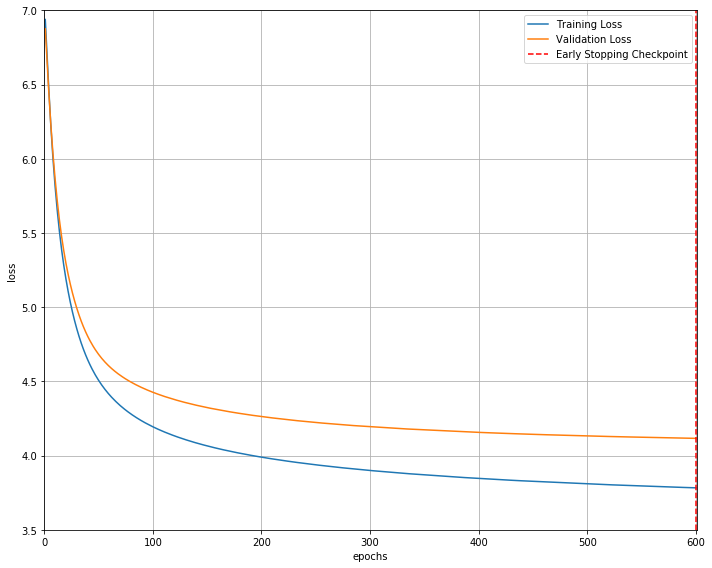

In [8]:
import matplotlib.pyplot as plt

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(3.5, 7) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('./SOFTMAX_trained/plots/loss_plot.png', bbox_inches='tight')

# LOADING & EVALUATING TRAINED MODEL

In [10]:
# loads the weights of a saved model and calculates and prints the following metrics: SpearManRank, MSE, MAE 
# look @ the data with TensorBoardX "tensorboard --logdir runs"

import torch
import os
from evaluation import Metrics

loadedModel = torch.load(os.path.join("SOFTMAX_trained", "smalldims.w2v"))
Metrics(loadedModel, indexes)

the cosine similarity between 🇬🇧 and 🇺🇸 could not be computed.
the cosine similarity between 🏅 and 🇺🇸 could not be computed.
the cosine similarity between 🇺🇸 and ❤ could not be computed.
the cosine similarity between 🇺🇸 and 💥 could not be computed.
the cosine similarity between 🎤 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 📲 could not be computed.
the cosine similarity between 👇 and 🇳🇬 could not be computed.
the cosine similarity between 🎧 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 🎶 could not be computed.
the cosine similarity between 👏 and ↪ could not be computed.

mein Spearman: 0.571855655199557
sein Spearman: 0.7590552598973165
mein MAE ist 0.38039831472298946
sein MAE ist 0.24206827309236947
mein MSE ist 0.19802350560456594
sein MSE ist 0.08023220381526104


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U4 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
